# COMP 4437 Week 11

### 1. Implement the Simple CNN Architecture (1 Point):
- Using PyTorch, implement a simple Convolutional Neural Network (CNN) architecture consisting of three convolutional layers and two fully connected layers. Ensure the network is capable of classifying images from the CIFAR-10 dataset.
- Provide the implementation of the model, its training loop, and validation loop.
#### Simple CNN Should achieve atleast 60% Test Accuracy


### 2. Improve the CNN Architecture and Implement Data Augmentation (1 Point):
- Modify the simple CNN architecture by adding ***Batch Normalization*** and ***Dropout*** layers to improve its performance. Justify your choices and implementation.

- Utilize PyTorch's `transforms` module to apply data augmentation techniques to the training data. Use methods such as random cropping, random flipping, and color jittering. Include this in your training pipeline and describe the effects of the augmentations on the training process.
#### Improved CNN with Data Augmentation should achieve atleast 70% Test Accuracy


#### Anything above 75% Test accuracy will receive an additional point.

### 3. Compare Performance:
- Train both the original CNN and the improved CNN (with Batch Normalization and Dropout) on the CIFAR-10 dataset.
- Track and compare the training, validation, and test accuracy and loss metrics for both models.
- Visualize and analyze the differences between the models' performances in a report.

### Requirements:
- Provide Python code that implements both the simple and improved CNN architectures.
- Implement data augmentation using PyTorch's `transforms` module.
- Use appropriate graphs to visualize the comparison of metrics for both models.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
num_epochs = 10

### Question 2 Data Augmentation Here

In [ ]:
"""
Add your own data augmentations here
Only Implement into train_transform
"""
# Data Loading with Augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomCrop(28)
    #transforms.RandomHorizontalFlip(1),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

In [ ]:
"""Dataset"""

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Sample Data Augmentations

Check Here for more:
https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended

In [ ]:
sample_image, _ = test_dataset[1]

# Convert the sample image to a PIL Image
if not isinstance(sample_image, Image.Image):
    sample_image = transforms.ToPILImage()(sample_image)

# Define augmentation transforms
augmentations = {
    "Original": transforms.Compose([transforms.ToTensor()]),
    "Random Horizontal Flip": transforms.Compose([transforms.RandomHorizontalFlip(1), transforms.ToTensor()]),
    "Random Vertical Flip": transforms.Compose([transforms.RandomVerticalFlip(1), transforms.ToTensor()]),
    "Random Crop": transforms.Compose([transforms.RandomCrop(28), transforms.ToTensor()]),
    "Color Jitter": transforms.Compose([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), transforms.ToTensor()]),
    "Random Rotation": transforms.Compose([transforms.RandomRotation(15), transforms.ToTensor()]),
    "Grayscale": transforms.Compose([transforms.Grayscale(3), transforms.ToTensor()]),
    "Gaussian Blur": transforms.Compose([transforms.GaussianBlur(3), transforms.ToTensor()]),
}

# Function to visualize the augmentations
def show_augmentations(image, transformations):
    num_transformations = len(transformations)
    fig, axs = plt.subplots(1, num_transformations, figsize=(20, 5))

    for ax, (name, transform) in zip(axs, transformations.items()):
        augmented_image = transform(image)
        augmented_image = augmented_image.permute(1, 2, 0)  # Rearrange tensor to [H, W, C]
        augmented_image = np.array(augmented_image)
        augmented_image = augmented_image[:, :, ::-1].copy()
        ax.imshow(augmented_image)
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the augmentations
show_augmentations(sample_image, augmentations)

### Simple Original CNN Architecture

1. **Input Layer**
   - **Size:** `(batch_size, 3, 32, 32)` (RGB images, 32x32 resolution)

2. **Layer 1: Convolution + Pooling**
   - **Conv Layer:** 32 filters, 3x3, padding 1
   - **MaxPool:** 2x2, stride 2
   - **Output Size:** `(batch_size, 32, 16, 16)`

3. **Layer 2: Convolution + Pooling**
   - **Conv Layer:** 64 filters, 3x3, padding 1
   - **MaxPool:** 2x2, stride 2
   - **Output Size:** `(batch_size, 64, 8, 8)`

4. **Layer 3: Convolution + Pooling**
   - **Conv Layer:** 128 filters, 3x3, padding 1
   - **MaxPool:** 2x2, stride 2
   - **Output Size:** `(batch_size, 128, 4, 4)`

5. **Flatten Layer**
   - **Flattens to:** `(batch_size, 128 * 4 * 4)`

6. **Fully Connected Layer 1 (fc1)**
   - **256 neurons, ReLU activation**
   - **Output Size:** `(batch_size, 256)`

7. **Fully Connected Layer 2 (fc2)**
   - **10 neurons** (CIFAR-10 classes)
   - **Output Size:** `(batch_size, 10)`

This architecture consists of three convolutional layers (with ReLU activations and pooling), followed by two fully connected layers for classification.


### Implement Original CNN Here (Question 1)

In [ ]:
"""
Original CNN
"""

class CNN(nn.Module):

  def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)


        self.l1 = nn.Linear(128*4*4, 256)
        self.l2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2, 0)


  def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


original_net = CNN().to(device)

### Implement Improved CNN Here (Question 2)

In [ ]:
"""
Improved CNN
"""

class CNN(nn.Module):

  def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.do1 = nn.Dropout2d(p=0.1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.l1 = nn.Linear(128*4*4, 256)
        self.l2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2, 0)


  def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.do1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


improved_net = CNN().to(device)

---

### Implement Train, Test and Validation Epochs

In [108]:
"""
Use these varaibles to keep track of the training, validation and test
"""

original_test_accuracy = None  #Float
improved_test_accuracy = None  #Float
original_train_losses, original_val_losses = [], []
original_train_accuracies, original_val_accuracies = [], []
improved_train_losses, improved_val_losses = [], []
improved_train_accuracies, improved_val_accuracies = [] ,[]

In [ ]:
"""
Implement Train, Test and Validation Epochs
"""

def train(dataloader, net):

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

  num_epochs = 5
  train_losses = []
  total = 0
  correct = 0


  size = len(dataloader.dataset)
  net.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = net(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      """
      train_losses.append(loss.item())
      _, predicted = torch.max(pred.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
      train_accuracy = 100 * correct / total
      """

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)

          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
     # return train_losses, train_accuracy

epochs = 5
for t in range(epochs):
    print(f"Epoch in original_net {t+1}\n-------------------------------")
    train(train_loader, original_net)
print("Done!")

epochs = 5
for t in range(epochs):
    print(f"Epoch in improved_net {t+1}\n-------------------------------")
    train(train_loader, improved_net)
print("Done!")

#original_train_losses, original_train_accuracies = train(train_loader, original_net)
#improved_train_losses, improved_val_losses = train(train_loader, improved_net)


"""
Validation Loop
"""
def Validation(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          """

          loss_fn = nn.CrossEntropyLoss()
          optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
          """


  print(f'Accuracy of the network on the test images: {100 * correct / total}%')
  #improved_val_accuracies.append(100 * correct / total)
  return 100 * correct / total

#original_val_losses, original_val_accuracies = Validation(original_net)
#improved_val_losses, improved_val_losses = Validation(improved_net)


original_test_accuracy = Validation(original_net)
improved_test_accuracy = Validation(improved_net)

Epoch in original_net 1
-------------------------------
loss: 0.874146  [   64/40000]
loss: 0.771489  [ 6464/40000]
loss: 0.762077  [12864/40000]
loss: 0.667482  [19264/40000]
loss: 0.761137  [25664/40000]
loss: 0.671516  [32064/40000]


In [ ]:
"""
Dummy Values to visualize

Delete this if you implemented your code correctly
"""
# Original model metrics (dummy data for illustration)
original_train_losses = [0.8, 0.6, 0.5, 0.45, 0.4]
original_val_losses = [0.9, 0.7, 0.6, 0.55, 0.5]
original_train_accuracies = [65, 70, 75, 78, 80]
original_val_accuracies = [60, 65, 70, 72, 75]

# Improved model metrics (dummy data for illustration)
improved_train_losses = [0.7, 0.55, 0.45, 0.4, 0.35]
improved_val_losses = [0.8, 0.65, 0.55, 0.5, 0.45]
improved_train_accuracies = [70, 75, 80, 83, 85]
improved_val_accuracies = [65, 70, 75, 77, 80]

original_test_accuracy = 75.6
improved_test_accuracy = 80.6


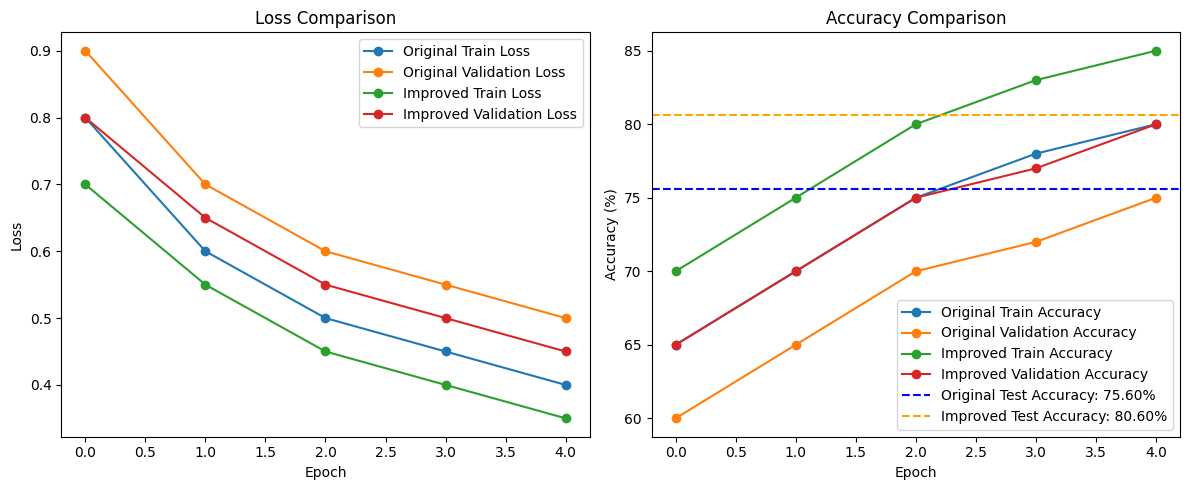

In [ ]:
# Plot Loss and Accuracy Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(original_train_losses, label='Original Train Loss', marker='o')
plt.plot(original_val_losses, label='Original Validation Loss', marker='o')
plt.plot(improved_train_losses, label='Improved Train Loss', marker='o')
plt.plot(improved_val_losses, label='Improved Validation Loss', marker='o')
plt.legend()
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(original_train_accuracies, label='Original Train Accuracy', marker='o')
plt.plot(original_val_accuracies, label='Original Validation Accuracy', marker='o')
plt.plot(improved_train_accuracies, label='Improved Train Accuracy', marker='o')
plt.plot(improved_val_accuracies, label='Improved Validation Accuracy', marker='o')
plt.axhline(original_test_accuracy, color='blue', linestyle='--', label=f'Original Test Accuracy: {original_test_accuracy:.2f}%')
plt.axhline(improved_test_accuracy, color='orange', linestyle='--', label=f'Improved Test Accuracy: {improved_test_accuracy:.2f}%')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()
